# Caterva performance against Zarr and HDF5

This benchmark is meant for comparing speeds of getting hyperplanes on a multidimensional
array using different backends: Caterva, zarr and HDF5.


In [1]:
import os
import cat4py as cat
import zarr
import numcodecs
import tables
import numpy as np
from time import time
import matplotlib.pyplot as plt
import shutil


In [2]:
# Dimensions for the arrays
shape = (1000, 250, 500)
chunkshape = (500, 20, 200)
blockshape = (50, 10, 50)

# Data type
dtype = "f8"

# Compression properties
cname = "zstd"
clevel = 5
filter = cat.SHUFFLE
nthreads = 6

persistent_store = True   # set it to False for pure in-memory operation

if persistent_store:
    cat_fname = "slicing.cat"
    zarr_fname = "slicing.zarr"
    hdf5_fname = "slicing.h5"
    for fname in (cat_fname, zarr_fname, hdf5_fname):
        if os.path.exists(fname):
            # Remove file on disk
            if "zarr" in fname:
                shutil.rmtree(fname)
            else:
                os.remove(fname)
else:
    cat_fname, zarr_fname, hdf5_fname = None, None, None


In [3]:
# Create content for populating arrays
# content = np.linspace(0, 1000, int(np.prod(shape))).reshape(shape)
content = np.random.normal(1., 1e-9, shape)


In [4]:
# Create and fill a caterva array
t0 = time()
a = cat.asarray(content, chunkshape=chunkshape, blockshape=blockshape,
                cname=cname, clevel=clevel, filters=[filter], nthreads=nthreads,
                filename=cat_fname)
t1 = time()
print("Time for filling array (caterva): %.3fs ; CRatio: %.1fx" % ((t1 - t0), a.cratio))

# Create and fill a zarr array
t0 = time()
compressor = numcodecs.Blosc(cname=cname, clevel=clevel, shuffle=filter)
numcodecs.blosc.set_nthreads(nthreads)
z = zarr.empty(shape=shape, chunks=chunkshape, dtype=dtype, compressor=compressor,
               store=zarr_fname)
z[:] = content
t1 = time()
print("Time for filling array (zarr): %.3fs ; CRatio: %.1fx" % ((t1 - t0), z.nbytes / z.nbytes_stored))

# Create and fill a hdf5 array
t0 = time()
filters = tables.Filters(complevel=clevel, complib="blosc:%s" % cname, shuffle=True)
tables.set_blosc_max_threads(nthreads)
if persistent_store:
    h5f = tables.open_file(hdf5_fname, 'w')
else:
    h5f = tables.open_file("whatever.h5", 'w', driver='H5FD_CORE', driver_core_backing_store=0)
h5ca = h5f.create_carray(h5f.root, 'carray', filters=filters, chunkshape=chunkshape, obj=content)
h5f.flush()
t1 = time()
print("Time for filling array (hdf5): %.3fs ; CRatio: %.1fx" % ((t1 - t0), h5ca.size_in_memory / h5ca.size_on_disk))


Time for filling array (caterva): 8.169s ; CRatio: 2.1x
Time for filling array (zarr): 8.532s ; CRatio: 2.1x
Time for filling array (hdf5): 37.776s ; CRatio: 2.1x


In [5]:
# Check that the contents are the same
t0 = time()
for block, info in a.iter_read(chunkshape):
    block_cat = block
    block_zarr = z[info.slice]
    np.testing.assert_array_almost_equal(block_cat, block_zarr)
    block_h5 = h5ca[info.slice]
    np.testing.assert_array_almost_equal(block_cat, block_h5)
t1 = time()
print("Time for checking contents: %.3fs" % (t1 - t0))


Time for checking contents: 5.653s


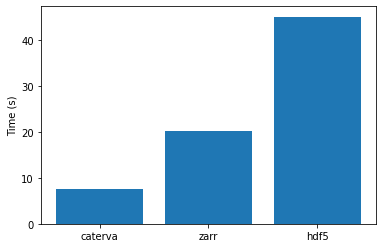

In [6]:
# Setup the coordinates for random planes in axis 0
planes_idx = np.random.randint(0, shape[0], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idx:
    block = a[i, :, :]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idx:
    block = z[i, :, :]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idx:
    block = h5ca[i, :, :]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()


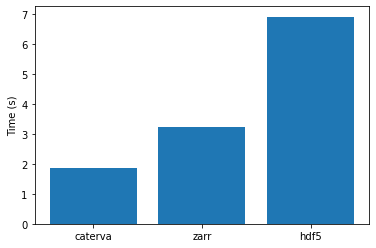

In [7]:
# Setup the coordinates for random planes in axis 1
planes_idy = np.random.randint(0, shape[1], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idy:
    block = a[:, i, :]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idy:
    block = z[:, i, :]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idy:
    block = h5ca[:, i, :]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()


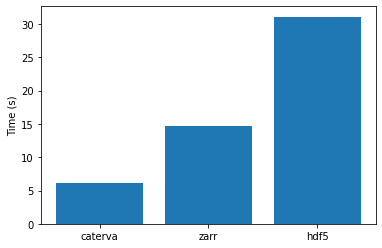

In [8]:
# Setup the coordinates for random planes in axis 2
planes_idz = np.random.randint(0, shape[2], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idz:
    block = a[:, :, i]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idz:
    block = z[:, :, i]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idz:
    block = h5ca[:, :, i]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()

In [9]:
h5f.close()